In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import glob
import seaborn as sns

In [2]:
group = "ODS" #'halocarbons'
fns = glob.glob(f"/user/home/lw13938/work/ciceroscm/RF_sensitivity/ensemble/outputs/ensemble_{group}*.nc")
ds_list = []
for fn in fns:
    ds_list = ds_list + [xr.open_dataset(fn)]
ds = xr.concat(ds_list, dim="ensemble")

In [3]:
from scipy.integrate import quad
def percentile_kde(x, density, percentiles=[5,95]):
    cumulative_density = np.cumsum(density) / np.sum(density)
    percentile_values = [x[np.searchsorted(cumulative_density, p / 100.0)] for p in percentiles]
    return percentile_values

# Quantile of a function
def prob_gt_zero(kde):
    prob_above_zero, _ = quad(kde, 0, np.inf)
    return prob_above_zero

def sig_figs(x: float, precision: int):
    x = float(x)
    precision = int(precision)
    if x == 0.:
        return 0
    else:
        return round(x, -int(np.floor(np.log10(abs(x)))) + (precision - 1))


CH4 -0.05271969769549743 [-0.08715516468505805, -0.0106319047082567] 0.019307571427709336
STRAT_O3 -0.1617621508168524 [-0.2533383809325144, -0.07205482335661212] 0.0016830634554938495
Total_forcing 0.11341460822807903 [-0.021822001275108083, 0.26016071641238847] 0.9179884723914449
direct_forcing 0.34734906520633885 [0.31075143642597647, 0.38477845827716395] 1.0
SO4_IND -0.001468429301581281 [-0.05986200760329982, 0.05568273244052624] 0.4807129033470854
aerosols -0.0006631696743546467 [-0.029145014455235832, 0.0271066289870045] 0.4807129033470854
TROP_O3 -0.016438780447829544 [-0.027831535127276163, -0.0033492325182525734] 0.019327287692531336
N2O 0.0005893350530576648 [0.0001255018928592262, 0.0009604015812164156] 0.9807170999682917
STRAT_H2O -0.004845731013681647 [-0.008010866962027111, -0.0009772315212594144] 0.019307571427709336
breakdown_products 0.006974949407752546 [0.0060846849461298255, 0.008043266761699811] 1.0


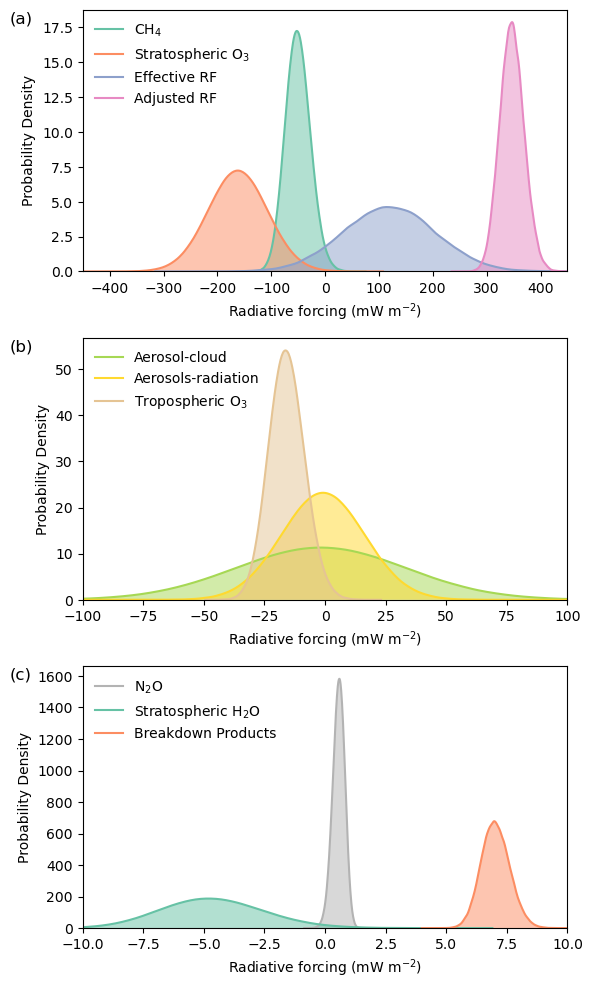

In [11]:
groups = [["CH4","STRAT_O3", "Total_forcing", "direct_forcing"],["SO4_IND", "aerosols","TROP_O3",], ["N2O", "STRAT_H2O","breakdown_products"]]
labels = ["CH$_4$", "Stratospheric O$_3$", "Effective RF", "Adjusted RF", "Aerosol-cloud", "Aerosols-radiation", "Tropospheric O$_3$", "N$_2$O", "Stratospheric H$_2$O", "Breakdown Products"]
colours = sns.color_palette("Set2", 10)
ind = ds.year.values == 2019
# limits = [[-0.45,0.45],[-0.1,0.1],[-0.01, 0.01]]*1000
# limits = [[None,None],[None,None],[None, None]]
limits = [[-450,450],[-100,100],[-10, 10]]
i = 0
fig, axes = plt.subplots(3, 1, figsize=(6,10))
for ax, group_vars,limit in zip(axes,groups, limits):
   # plt.figure(figsize=(10,4))
   for var in group_vars:
      if var == "aerosols":
         forcing_arr = ds["OC"][:,ind,:].values.ravel() + ds["SO4_DIR"][:,ind,:].values.ravel()
      else:
         forcing_arr = ds[var][:,ind,:].values.ravel()
         if np.all(np.isclose(forcing_arr,forcing_arr[0], atol=1e-6)):
            continue
         addabit = abs(forcing_arr.max() - forcing_arr.min())*0.1
      kde_x = np.linspace(forcing_arr.min()-addabit , forcing_arr.max()+addabit, 300)
      kernel = stats.gaussian_kde(forcing_arr)
      rfkde = kernel(kde_x)
      imode = rfkde.argmax()
      col = colours[i]
      ax.plot(kde_x*1000, rfkde, color=col, label=labels[i]) #label=var, 
      # Fill under the curve
      ax.fill_between(kde_x*1000, 0, rfkde, alpha=0.5, facecolor=col)
      i = i + 1
      print(var, kde_x[imode], percentile_kde(kde_x, rfkde), 1- kernel.integrate_box_1d(-np.inf, 0))
      # print(var, kde_x[imode], percentile_kde(kde_x, rfkde, percentiles=[16,84]), 1- kernel.integrate_box_1d(-np.inf, 0))
      
   ax.set_xlabel("Radiative forcing (mW m$^{-2}$)")
   ax.set_ylabel("Probability Density")
   ax.set_xlim(limit)
   ax.legend(loc="upper left", frameon=False)
   ax.set_ylim(bottom=0)
   # Plot letter labels a-c
   ax.text(-0.15, 0.95, f"({chr(97+axes.tolist().index(ax))})", transform=ax.transAxes, fontsize=12)
plt.tight_layout()
plt.savefig(f"/user/home/lw13938/work/ciceroscm/RF_sensitivity/Figs/ensemble_{group}_2019.png", dpi=300)

In [60]:
sig_figs(0.38477845827716395, 2)

0.38

Text(0.5, 0, 'Year')

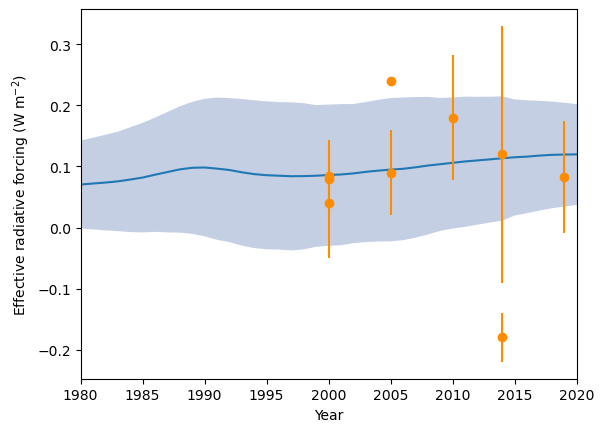

In [15]:
erf_dict = {
    "oconnor" : [2014, -0.18,  0.04],
    "morgenstern" : [2000, 0.04, 0.09],
    "chiodo" : [2005, 0.24, 0],
    "thornhill": [2014, 0.12, 0.21],
    "ar6" : [2019, 0.083, 0.0918],
    "ar5" : [2010, 0.18, 0.103],
    "mogenstern2" : [2000,0.085, 0.059],
    "sodve" : [2000, 0.08, 0],    
    "shindell" : [2005,0.09,0.07],
    
}


data = ds["Total_forcing"]
flattened_data = data.stack(points=("ensemble", "sample")).values
plt.plot(ds.year.values, np.mean(flattened_data,1))
lower = np.percentile(flattened_data, 16, axis=1)
upper = np.percentile(flattened_data, 84, axis=1)
plt.fill_between(ds.year.values, lower, upper, alpha=0.5, facecolor=colours[2])
for key in erf_dict.keys():
    plt.errorbar(erf_dict[key][0], erf_dict[key][1], yerr=erf_dict[key][2], fmt='o', label=key, color="darkorange")

plt.xlim(1980, 2020)
plt.ylabel("Effective radiative forcing (W m$^{-2}$)")
plt.xlabel("Year")
# plt.savefig(f"/user/home/lw13938/work/ciceroscm/RF_sensitivity/Figs/ERF_timeseries.png", dpi=300)

In [67]:
groups = {"all":[],
          "CFCs": ["cfc11", "CFC-12", "CFC-113", "CFC-114", "CFC-115","CFC-13"],
          "HCFCs": ["HCFC-22", "HCFC-141b", "HCFC-142b", "HCFC-124", "HCFC-133a", "HCFC-123"],
          "HFCs": ["HFC-23", "HFC-32", "HFC-134a", "HFC-143a", "HFC-125",
                   "HFC-152a", "HFC-4310mee", "HFC-227ea", "HFC-365mfc",
                   "HFC-236fa", "HFC-245fa"], 
          "Solvents": ["CCl4", "CH3CCl3"],
          "PFCs":["CF4", "C2F6", "C3F8", "C4F8", "C4F10","C6F14"],
          "Other":["SF6", "NF3","SO2F2"],
          "Halons": ["H-1301", "H-2402", "H-1211"],
          "CH3Br": ["CH3Br"]}

# Gases to ger ERF for
csmsp = groups["CFCs"]+groups["HCFCs"]+groups["Solvents"]+groups["Halons"]+groups["CH3Br"]
# csmsp = ["ODS", "cfcs", "hcfcs","Solvents","halons"]
groups = ["direct_forcing", "Total_forcing","STRAT_O3","CH4","SO4_IND", "aerosols","TROP_O3", "N2O", "STRAT_H2O","breakdown_products"]
print([f"{g} & " for g in groups])
for group in csmsp:
    if group == "HCFC-123":
        continue
    fns = glob.glob(f"/user/home/lw13938/work/ciceroscm/RF_sensitivity/ensemble/outputs/ensemble_{group}*.nc")
    ds_list = []
    for fn in fns:
        ds_list = ds_list + [xr.open_dataset(fn)]
    ds = xr.concat(ds_list, dim="ensemble")
    outval = np.zeros(len(groups))
    lower = np.zeros(len(groups))
    upper = np.zeros(len(groups))
    ind = ds.year.values == 2019
    i = 0
    for var in groups:
        if var == "aerosols":
            forcing_arr = ds["OC"][:,ind,:].values.ravel() + ds["SO4_DIR"][:,ind,:].values.ravel()
        else:
            forcing_arr = ds[var][:,ind,:].values.ravel()
            if np.all(np.isclose(forcing_arr,forcing_arr[0], atol=1e-6)):
                i = i + 1
                continue
            addabit = abs(forcing_arr.max() - forcing_arr.min())*0.1
        kde_x = np.linspace(forcing_arr.min()-addabit , forcing_arr.max()+addabit, 300)
        kernel = stats.gaussian_kde(forcing_arr)
        rfkde = kernel(kde_x)
        imode = rfkde.argmax()
        outval[i] = kde_x[imode]
        lower[i], upper[i] = percentile_kde(kde_x, rfkde)
        i = i + 1
    # print(f"{group} &" + "&".join([f" {sig_figs(m,2)} ({sig_figs(l,2)}, {sig_figs(u,2)}) " for m,l,u in zip(outval*1000, 1000*lower, 1000*upper)]) )

    print(f"{group} &" + "&".join([f" {np.round(1000*m,1)} " for m in outval]) + "\\\\")
    print(f"  &" + "&".join([f"({np.round(1000*l,1)}, {np.round(1000*u,1)}) " for l,u in zip(lower, upper)]) + "\\\\" )

        
        # print(var, kde_x[imode], percentile_kde(kde_x, rfkde, percentiles=[16,84]))
      

['direct_forcing & ', 'Total_forcing & ', 'STRAT_O3 & ', 'CH4 & ', 'SO4_IND & ', 'aerosols & ', 'TROP_O3 & ', 'N2O & ', 'STRAT_H2O & ', 'breakdown_products & ']
cfc11 & 62.0 & 0.4 & -43.9 & -13.2 & -0.5 & -0.2 & -4.1 & 0.1 & -1.2 & 1.6 \\
  &(52.3, 73.2) &(-35.6, 40.6) &(-68.8, -19.0) &(-21.1, -2.8) &(-16.4, 15.4) &(-7.9, 7.5) &(-6.8, -0.9) &(0.0, 0.2) &(-1.9, -0.3) &(1.2, 2.1) \\
CFC-12 & 176.7 & 129.0 & -34.9 & -10.0 & -0.2 & -0.1 & -3.2 & 0.1 & -0.9 & 2.6 \\
  &(145.5, 213.8) &(88.6, 178.7) &(-54.6, -15.2) &(-16.1, -2.2) &(-13.0, 12.2) &(-6.3, 6.0) &(-5.2, -0.6) &(0.0, 0.2) &(-1.5, -0.2) &(2.0, 3.4) \\
CFC-113 & 20.7 & 8.2 & -9.1 & -2.6 & -0.1 & -0.1 & -0.8 & 0.0 & -0.2 & 0.5 \\
  &(16.9, 25.1) &(0.1, 17.2) &(-14.2, -4.0) &(-4.2, -0.6) &(-3.4, 3.2) &(-1.6, 1.6) &(-1.4, -0.2) &(0.0, 0.0) &(-0.4, -0.1) &(0.4, 0.6) \\
CFC-114 & 5.3 & 4.5 & -0.6 & -0.2 & -0.0 & -0.0 & -0.1 & 0.0 & -0.0 & 0.0 \\
  &(4.4, 6.5) &(3.4, 5.7) &(-1.0, -0.3) &(-0.3, -0.0) &(-0.2, 0.2) &(-0.1, 0.1) &(-0.1, -0.0)

Text(0, 0.5, 'Change in CH$_4$ lifetime (%)')

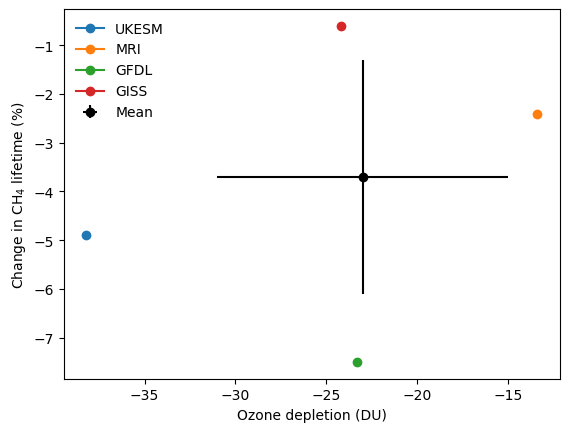

In [60]:
DU = {"CNRM":-23.4,
      "UKESM":-38.2,
      "MRI":-13.4,
      "GFDL":-23.3,
      "GISS":-24.2,
      "CESM":-22.7,
       }
ch4 = {"UKESM":-4.9,
       "GFDL":-7.5,
       'GISS':-0.6,
       "MRI":-2.4}

for key in DU.keys():
    if key in ch4.keys():
        plt.plot(DU[key], ch4[key], marker="o", label=key)
plt.errorbar(-23., -3.7, xerr=8, yerr=2.4, fmt="o", color="black", label="Mean")
plt.legend(loc="upper left", frameon=False)
plt.xlabel("Ozone depletion (DU)")
plt.ylabel("Change in CH$_4$ lifetime (%)")

In [25]:
(0.12902330865688286+0.0003801595701588417)/0.11341460822807903

1.140977077369158